In [4]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
from arch import arch_model
from arch.univariate import ConstantMean
import mgarch
from datetime import date

In [5]:
Bank_data = pd.read_csv("Bank_data_full_2.csv")
Bank_data = Bank_data.drop(['PERMNO','PERMCO'], axis = 1)

Bank_data_other = pd.read_csv("Bank_data_full_2.csv")
Bank_data_other = Bank_data_other.drop(['PERMNO','PERMCO'], axis = 1)



SP_index = pd.read_csv("SP_500_Data.csv")
sector_data = pd.read_csv("48_Industry_Portfolios_Daily.csv")
sector_data = sector_data.rename(columns={sector_data.columns[0]:'Date'})
sector_data.head()

sector_data.iloc[:, 0] = pd.to_datetime(sector_data.iloc[:, 0].astype(str), format='%Y%m%d', errors='coerce')

sector_data = sector_data[['Date','Aero', 'Guns', 'Ships','Oil', 'Coal', 'Util']].copy()

sector_data = sector_data.loc[:26132]




/var/folders/0q/vd9_j4p16sxdmvrf02mwf33m0000gn/T/ipykernel_20384/2074775263.py:1: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  Bank_data = pd.read_csv("Bank_data_full_2.csv")
/var/folders/0q/vd9_j4p16sxdmvrf02mwf33m0000gn/T/ipykernel_20384/2074775263.py:4: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  Bank_data_other = pd.read_csv("Bank_data_full_2.csv")
/var/folders/0q/vd9_j4p16sxdmvrf02mwf33m0000gn/T/ipykernel_20384/2074775263.py:10: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48) have mixed types. Specify dtype option on import or set low_memory=False.
  sector_data = pd.read_csv("48_Industry_Portfolios_Daily.csv")


In [6]:
Bank_data_other['Market_Cap'] = Bank_data_other['PRC'].values*Bank_data_other['SHROUT'].values


In [7]:
sector_data.set_index('Date', inplace=True)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/indexes/base.py:7654: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


In [8]:
sector_data = sector_data.sort_index()
sector_data = sector_data[ (sector_data.index >= '2000-01-03') & (sector_data.index <= '2009-12-31') ].copy()


In [9]:

SP_index = SP_index.rename(columns={'caldt':'Date','sprtrn': 'Ret'})

SP_index.set_index('Date', inplace=True)

In [10]:
SP_index = SP_index.sort_index()

SP_index = SP_index[ (SP_index.index >= '2000-01-03') & (SP_index.index <= '2009-12-31') ].copy()

In [11]:
sector_data = sector_data.apply(pd.to_numeric, errors='coerce')

In [12]:
Defence_index = pd.DataFrame()
Energy_index = pd.DataFrame()

Defence_index = 1/3*sector_data['Aero'].values+1/3*sector_data['Guns'].values+1/3*sector_data['Ships'].values
Energy_index = 1/3*sector_data['Oil'].values+1/3*sector_data['Coal'].values+1/3*sector_data['Util'].values

In [13]:
Defence_index  = pd.DataFrame(Defence_index, index = sector_data.index)

Energy_index = pd.DataFrame(Energy_index,index=sector_data.index)

Defence_index = Defence_index
Energy_index = Energy_index
Energy_index.head()

,0
Date,
2000-01-03,-0.773333
2000-01-04,-2.586667
2000-01-05,1.183333
2000-01-06,0.460000
2000-01-07,1.623333


In [14]:
SP_index.columns

Index(['Ret'], dtype='object')

In [15]:
Geo_Pol_long = pd.DataFrame()
Geo_Pol_short = pd.DataFrame()
Geo_Pol_index = pd.DataFrame()

Geo_Pol_long = 0.5*Defence_index.values+0.5*Energy_index.values # in percentage
Geo_Pol_long = pd.DataFrame(Geo_Pol_long, index = Energy_index.index)

Geo_Pol_short = -SP_index.values*100 # from decimal to percentage


In [16]:
Geo_Pol_index = Geo_Pol_long+Geo_Pol_short


In [17]:
Bank_data['date'] = pd.to_datetime(Bank_data['date'])
Bank_data.set_index('date', inplace=True)

In [18]:
Bank_data_other['date'] = pd.to_datetime(Bank_data_other['date'])
Bank_data_other.set_index('date', inplace=True)

In [19]:
Bank_data= Bank_data.sort_index()

Bank_data = Bank_data[ (Bank_data.index >= '2000-01-03') & (Bank_data.index <= '2009-12-31') ].copy()

In [20]:
Bank_data_other = Bank_data_other.sort_index()

Bank_data_other = Bank_data_other[ (Bank_data_other.index >= '2000-01-03') & (Bank_data_other.index <= '2009-12-31') ].copy()

In [21]:

Bank_data = {ticker: group for ticker, group in Bank_data.groupby('TICKER')}

In [22]:

Bank_data_other = {ticker: group for ticker, group in Bank_data_other.groupby('TICKER')}


In [23]:
X = np.column_stack([SP_index.values, Geo_Pol_index.values])
X = sm.add_constant(X)


results = {}




In [24]:
for ticker,y in Bank_data.items():

    if len(y)==len(SP_index):

        ys = y['RET'].astype(float).values
        X_ = X.astype(float)
        model = sm.OLS(ys, X).fit()
        results[ticker] = model





In [25]:
market_caps = [np.mean(y['Market_Cap']) for y in Bank_data_other.values()]
threshold = np.percentile(market_caps, 90)
print("Market Cap threshold for top 10% banks:", threshold)

Market Cap threshold for top 10% banks: 3968542.461810585


In [26]:
results_other = {}
for ticker,y in Bank_data_other.items():


    if len(y)==len(SP_index)and np.mean(y['Market_Cap'])>threshold:

        ys = y['RET'].astype(float).values
        X_ = X.astype(float)
        model = sm.OLS(ys, X).fit()
        results_other[ticker] = model





In [27]:
neg_x2 = {}

x2_idx = 2
for ticker, model in results.items():

    x2_coef = model.params[x2_idx]
    x2_tval = model.tvalues[x2_idx]

    if x2_coef < 0 and np.abs(x2_tval) > 2 :
        neg_x2[ticker] = {
            'x2_coef': x2_coef,
            'x2_tvalue': x2_tval,
            'results': model.summary()
        }

for ticker, vals in neg_x2.items():
    print(ticker, vals['x2_coef'], vals['x2_tvalue'],'\n', vals['results'])

ASBC -0.001727848005146653 -4.027762290308861 
                             OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.422
Model:                            OLS   Adj. R-squared:                  0.422
Method:                 Least Squares   F-statistic:                     917.3
Date:                Wed, 21 Jan 2026   Prob (F-statistic):          8.10e-300
Time:                        10:27:54   Log-Likelihood:                 6421.9
No. Observations:                2515   AIC:                        -1.284e+04
Df Residuals:                    2512   BIC:                        -1.282e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
cons

In [28]:
neg_x2_other = {}

for ticker, model in results_other.items():

    x2_coef = model.params[x2_idx]
    x2_tval = model.tvalues[x2_idx]

    if x2_coef < 0 and np.abs(x2_tval) > 2 :
        neg_x2_other[ticker] = {
            'x2_coef': x2_coef,
            'x2_tvalue': x2_tval
        }

for ticker, vals in neg_x2_other.items():
    print(ticker, vals['x2_coef'], vals['x2_tvalue'])

AXP -0.0020038601085726757 -4.938585571461137
BAC -0.0023095992414879406 -3.778224439791024
BBT -0.0020075566024500345 -4.677709263390896
BK -0.0018009422008918522 -3.885234508830773
COF -0.0025003250163428766 -3.8851696413583316
MI -0.002021852352599731 -3.1103957213450526
MTB -0.0016210196193672589 -4.01488983769196
NTRS -0.002022217990977379 -4.895078166848271
SNV -0.002501735058182218 -3.9107687255608017
STI -0.003737458772600229 -6.384796789373873
USB -0.0027596900955526925 -5.835784910980067
WFC -0.0019081370057443432 -3.590804241967646


# Prepare Exog neg returns Indicator 

In [29]:
r_minus = [i if i < 0 else 0 for i in SP_index['Ret']]


In [30]:
len(r_minus)

2515

In [31]:
print(r_minus)

[-0.009549, -0.038345, 0, 0, 0, 0, -0.013063, -0.004386, 0, 0, -0.006832, 0, -0.007095, -0.002912, -0.027634, 0, -0.004213, -0.003938, -0.027457, 0, 0, -0.000114, 0, -0.000421, -9.1e-05, 0, -0.020822, 0, -0.020969, 0, 0, -0.010256, 0, -0.030376, 0, 0, -0.005336, -0.014829, 0, 0, 0, 0, 0, -0.012695, -0.025631, 0, 0, -0.004723, -0.008207, -0.017685, 0, 0, 0, -0.005353, 0, 0, 0, 0, -0.002357, -0.010585, 0, -0.013656, 0, 0, -0.007464, -0.004924, 0, 0, -0.007841, -0.002572, -0.022271, -0.018171, -0.058278, 0, 0, -0.009808, 0, -0.003262, 0, -0.011134, 0, -0.008526, 0, -0.014957, -0.021566, -0.003908, 0, -0.005905, -0.008447, -0.0206, 0, 0, 0, 0, -0.012442, -0.007315, -0.021055, -0.004428, -0.019176, 0, -0.01253, -0.002533, 0, -0.001301, 0, 0, -0.006519, -0.006671, 0, -0.006586, -0.003229, -0.007516, 0, 0, 0, -0.00965, 0, -0.006763, 0, -0.01822, -0.007368, 0, -0.003271, 0, -0.008544, 0, 0, -0.015862, 0, 0, -0.002218, 0, 0, 0, 0, 0, -0.011089, -0.007886, 0, -0.010284, -0.010742, 0, -0.014955, 

# Prepare GPR index from monthly data (test instead of current index)

In [32]:

gpr_data = pd.read_csv('./data_gpr_export.csv')


In [33]:
gpr_data.head()

,month,GPR,GPRT,GPRA,GPRH,GPRHT,GPRHA,SHARE_GPR,N10,SHARE_GPRH,...,GPRHC_TUN,GPRHC_TUR,GPRHC_TWN,GPRHC_UKR,GPRHC_USA,GPRHC_VEN,GPRHC_VNM,GPRHC_ZAF,var_name,var_label
0,01/01/1900,NaN,NaN,NaN,87.93,64.72,110.45,NaN,NaN,3.17,...,0.0,0.04,0.0,0.0,2.72,0.05,0.01,1.15,month,Date (year/month)
1,01/02/1900,NaN,NaN,NaN,86.57,71.94,96.25,NaN,NaN,3.12,...,0.0,0.13,0.0,0.0,2.73,0.03,0.00,1.14,GPR,Recent GPR (Index: 1985:2019=100)
2,01/03/1900,NaN,NaN,NaN,72.14,57.48,84.50,NaN,NaN,2.60,...,0.0,0.18,0.0,0.0,2.15,0.03,0.00,0.86,GPRT,Recent GPR Threats (Index: 1985:2019=100)
3,01/04/1900,NaN,NaN,NaN,54.42,37.33,65.86,NaN,NaN,1.96,...,0.0,0.07,0.0,0.0,1.78,0.00,0.00,0.64,GPRA,Recent GPR Acts (Index: 1985:2019=100)
4,01/05/1900,NaN,NaN,NaN,64.41,48.20,74.37,NaN,NaN,2.32,...,0.0,0.08,0.0,0.0,1.97,0.01,0.00,0.79,GPRH,Historical GPR (Index: 1900:2019=100)


In [34]:
# create gpr_t_index_monthly by taking only the month columnn and GPRT column from gpr_data
gpr_data['Date'] = pd.to_datetime(gpr_data['month'], format='%d/%m/%Y')
gpr_t_index_monthly = gpr_data[['Date', 'GPRT']].copy()
gpr_t_index_monthly.set_index('Date', inplace=True)

In [35]:
gpr_t_index_monthly = gpr_t_index_monthly[
    (gpr_t_index_monthly.index >= '1999-12-01') & 
    (gpr_t_index_monthly.index <= '2010-01-31')    
]

In [36]:
# interpolate monthly data to daily data 
gpr_t_index_daily = gpr_t_index_monthly.resample('D').ffill()

In [37]:
# match gpr dates to SP_index dates
gpr_t_index_daily = gpr_t_index_daily.loc[gpr_t_index_daily.index.isin(SP_index.index)]

/var/folders/0q/vd9_j4p16sxdmvrf02mwf33m0000gn/T/ipykernel_20384/726057541.py:2: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  gpr_t_index_daily = gpr_t_index_daily.loc[gpr_t_index_daily.index.isin(SP_index.index)]


In [38]:
gpr_t_index_daily['GPRT_change'] = gpr_t_index_daily['GPRT'].diff().fillna(0)
gpr_t_index_daily.head()

,GPRT,GPRT_change
Date,,
2000-01-03,65.57,0.0
2000-01-04,65.57,0.0
2000-01-05,65.57,0.0
2000-01-06,65.57,0.0
2000-01-07,65.57,0.0


In [39]:
len(gpr_t_index_daily)

2515

# Prepare log returns + scaling

In [52]:
# scaling 
scale_i = 100  # log(1+r)*10 ≈ r*10
scale_mkt = 1  # S&P 500 return without scaling
scale_r_m = 100 # negative market return *100
# scale_g = 100 


In [53]:
# data prep 

for ticker ,y in Bank_data.items():
    y['RET'] = pd.to_numeric(y['RET'], errors='coerce')
    y['RET'] = y['RET'].interpolate(method='linear', limit=2) 
    y['RET'] = y['RET'].fillna(0.0)
    y['logRET'] = np.log1p((y['RET'].copy()).astype(float).values)
    y['logRET'] = y['logRET']*scale_i
    Bank_data[ticker]['logRET'] = y['logRET']

In [81]:
len(y)

2515

# GJR-GARCH

In [54]:
x = r_minus.copy()
x = np.array(x) * scale_r_m
x = sm.add_constant(x)

sigma_i = {}
res_i = {} 
z_i = {}

for ticker,y in Bank_data.items():
    if len(y)==len(r_minus):
        ys = y['logRET'].values
        model_i = arch_model(ys,x, vol='Garch', p=1, q=1)
        res_i[ticker] = model_i.fit(disp='off')
        sigma_i[ticker] = res_i[ticker].conditional_volatility
        z_i[ticker] = res_i[ticker].resid / sigma_i[ticker]
        
rm = SP_index['Ret'].values * scale_mkt
model_m = arch_model(rm,x, vol='Garch', p=1, q=1)
res_m = model_m.fit(disp='off')
sigma_m = res_m.conditional_volatility
z_m = res_m.resid / sigma_m

fgeo = Geo_Pol_index.values
# fgeo = np.log(gpr_t_index_daily['GPRT']).diff().fillna(0).values * scale_g # get log diffs
model_geo = arch_model(fgeo, x, vol='Garch', p=1, q=1)
res_geo = model_geo.fit(disp='off')
sigma_geo = res_geo.conditional_volatility
z_geo = res_geo.resid / sigma_geo




/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000196. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [55]:
fgeo

array([[-1.8801    ],
       [ 2.95116667],
       [ 1.52946667],
       ...,
       [-0.09156667],
       [-0.2645    ],
       [-0.2       ]])

# DCC 

In [67]:
def extract_R_t(model, a, b):
    a = a
    b = b
    D_t = model.D_t  # T x N conditional volatilities
    rt = model.rt    # T x N returns (mean-centered)
    T = rt.shape[0]
    N = rt.shape[1]
    
    Q_bar = np.cov(rt.T)  # Long-run correlation
    Q_t = np.zeros((T, N, N))
    R_t = np.zeros((T, N, N))
    
    Q_t[0] = np.matmul(rt[0].T / 2, rt[0] / 2)
    
    for i in range(1, T):
        dts = np.diag(D_t[i])
        dtinv = np.linalg.inv(dts)
        et = dtinv @ rt[i].T  # Standardized residuals
        
        Q_t[i] = (1 - a - b) * Q_bar + a * (et * et.T) + b * Q_t[i - 1]
        qts = np.linalg.inv(np.sqrt(np.diag(np.diag(Q_t[i]))))
        
        R_t[i] = qts @ Q_t[i] @ qts  # Normalized correlation
    
    return R_t  # T x N x N array of correlation matrices

In [65]:
for ticker in z_i.keys():
    print(ticker)

ABCB
AIB
ASBC
AXP
BAC
BAP
BARI
BBT
BCS
BFR
BHB
BK
BLX
BMO
BMRC
BOH
BPOP
BUSE
BXS
CACB
CASS
CATY
CBAN
CEBK
COF
CWLZ
ECBE
FBP
FCF
FRGB
FTBK
FWV
GBCI
HBC
HBHC
IBCP
ING
IRE
MFLR
MI
MSL
MTB
MUC
NBG
NBN
NOVB
NTRS
OFG
OZRK
PRSP
RY
SAN
SBSI
SGB
SNV
STD
STI
STT
TD
TIBB
TMP
TRST
UBSH
UNTY
USB
VLY
WBK
WCBO
WFC
WL
YAVY


In [ ]:
R_t_dict = {}
models = {}
a_s = []
b_s = []
for ticker in z_i.keys():
    # ticker = 'BAC'
    z_stack = np.column_stack([z_i[ticker], z_m, z_geo])
    mgarch_model = mgarch.mgarch()
    mgarch_model.fit(returns=z_stack)
    a_s.append(mgarch_model.a)
    b_s.append(mgarch_model.b)
    models[ticker] = mgarch_model
a_median = np.median(a_s)
b_median = np.median(b_s)


In [68]:
for ticker in z_i.keys():
# calculate model for all banks to get a,b and get medians to calculate R_t for each bank
    R_t = extract_R_t(models[ticker], a=a_median, b=b_median)
    R_t_dict[ticker] = R_t

In [59]:
len(R_t)

2515

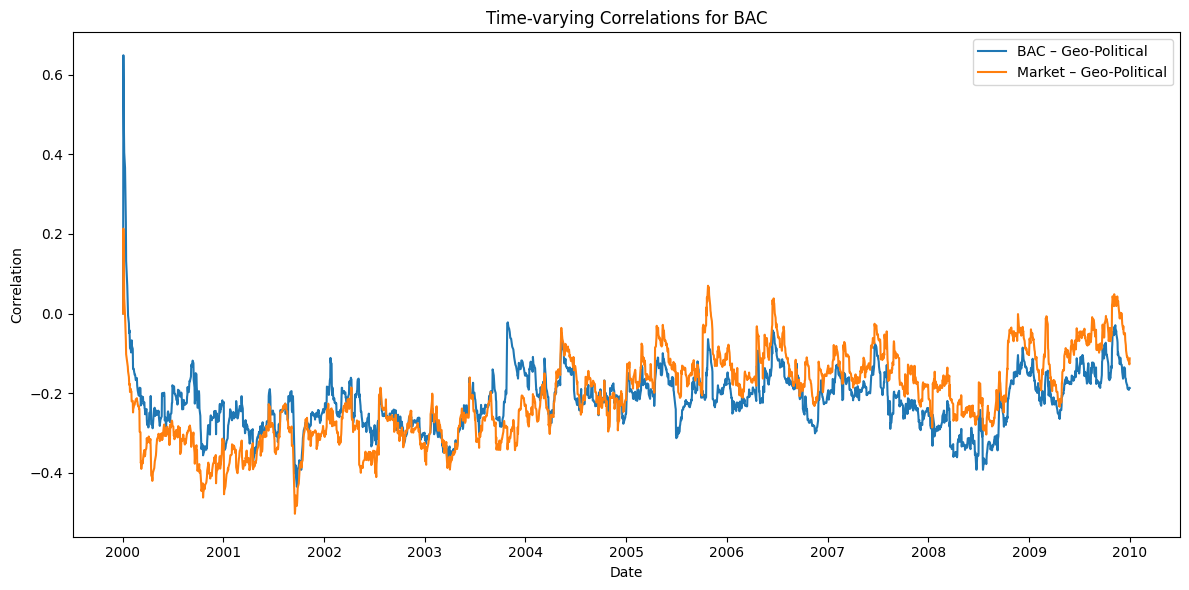

In [60]:
import matplotlib.pyplot as plt

ticker = 'BAC'
R_t = R_t_dict[ticker]

# Assume returns_df was used to compute R_t
dates = y.index  # ← exact trading days used

plt.figure(figsize=(12, 6))

plt.plot(dates, R_t[:, 0, 2], label='BAC – Geo-Political')
plt.plot(dates, R_t[:, 1, 2], label='Market – Geo-Political')

plt.title(f'Time-varying Correlations for {ticker}')
plt.xlabel('Date')
plt.ylabel('Correlation')
plt.legend()
plt.tight_layout()
plt.show()


In [70]:
beta_t = {}
ticker = 'BAC'

for ticker in z_i.keys():
    R = R_t_dict[ticker]
    rho_im = R[:, 0, 1]
    rho_ig = R[:, 0, 2]
    rho_mg = R[:, 1, 2]

    T = R.shape[0]

    sigma_i_aligned = sigma_i[ticker][-T:]  
    sigma_m_aligned = sigma_m[-T:]
    sigma_geo_aligned = sigma_geo[-T:]


    Sigma_FF = np.zeros((T, 2, 2))
    Sigma_FF[:, 0, 0] = sigma_m_aligned**2
    Sigma_FF[:, 1, 1] = sigma_geo_aligned**2
    Sigma_FF[:, 0, 1] = rho_mg * sigma_m_aligned * sigma_geo_aligned
    Sigma_FF[:, 1, 0] = Sigma_FF[:, 0, 1]

    Sigma_iF = np.zeros((T, 2))
    Sigma_iF[:, 0] = rho_im * sigma_i_aligned * sigma_m_aligned      # Cov(BAC, market)
    Sigma_iF[:, 1] = rho_ig * sigma_i_aligned * sigma_geo_aligned    # Cov(BAC, geo)

    # Sigma_FF_inv = np.linalg.inv(Sigma_FF)  # (T, 2, 2)

    beta_t_temp = np.zeros((T, 2))
    for t in range(T):
        beta_t_temp[t, :] = np.linalg.solve(Sigma_FF[t], Sigma_iF[t])

    beta_t[ticker] = beta_t_temp
    
# beta_t['BAC'] = np.matmul(Sigma_FF_inv, Sigma_iF)  # (T, 2, 1)

In [82]:
# get mean beta for each t from top percentile of banks  (just for testing)
mean_beta_t_geo = np.zeros(T)
mean_beta_t_mkt = np.zeros(T)
for t in range(T):
    betas_geo = []
    betas_mkt = []
    for ticker in z_i.keys():
        betas_mkt.append(beta_t[ticker][t, 0])
        betas_geo.append(beta_t[ticker][t, 1])
    mean_beta_t_geo[t] = np.median(betas_geo)
    mean_beta_t_mkt[t] = np.median(betas_mkt)
    
    

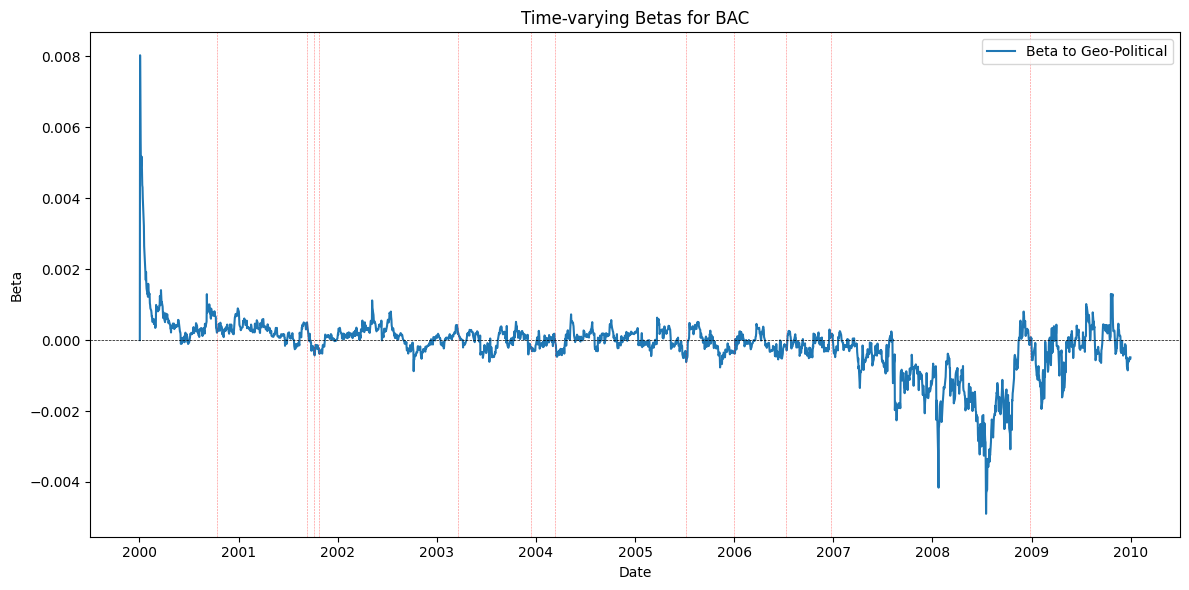

In [ ]:
dates_aligned = y.index[-T:]

ticker = 'BAC'
betat_geo = beta_t[ticker][:, 1]
betat_mkt = beta_t[ticker][:, 0]

events = {
    # --- Early 2000s ---
    'USS Cole Bombing': pd.Timestamp('2000-10-12'),

    # --- 9/11 and War on Terror ---
    '9/11 Attacks': pd.Timestamp('2001-09-11'),
    'Afghanistan War Begins': pd.Timestamp('2001-10-07'),
    'Patriot Act Signed': pd.Timestamp('2001-10-26'),

    # --- Middle East conflicts ---
    'Iraq Invasion': pd.Timestamp('2003-03-20'),
    'Capture of Saddam Hussein': pd.Timestamp('2003-12-13'),
    'Madrid Train Bombings': pd.Timestamp('2004-03-11'),

    # --- Terrorism in financial centers ---
    'London Bombings': pd.Timestamp('2005-07-07'),

    # --- Energy & geopolitical tension ---
    'Russia–Ukraine Gas Dispute': pd.Timestamp('2006-01-01'),
    'Israel–Hezbollah War': pd.Timestamp('2006-07-12'),
    'Iran Nuclear Sanctions Escalation': pd.Timestamp('2006-12-23'),

    # --- Late period ---
    'Gaza War': pd.Timestamp('2008-12-27')
}

beta_geo_rescaled = mean_beta_t_geo / scale_i #mean of betas of 10% of banks
plt.figure(figsize=(12, 6))
plt.plot(dates_aligned, beta_geo_rescaled, label='Beta to Geo-Political')
plt.axhline(y=0, color='black', linestyle='--', linewidth=0.5)
for event, date in events.items():
    plt.axvline(x=date, color='red', linestyle='--', linewidth=0.4, alpha=0.5)
plt.title('Time-varying Betas for BAC')
plt.xlabel('Date')
plt.ylabel('Beta')
plt.legend()
plt.tight_layout()
plt.show()

In [79]:
# Diagnostic output
crisis_periods = {
    '9/11': ('2001-09-11', '2001-12-31'),
    'Iraq War': ('2003-03-01', '2003-06-30'),
    'Financial Crisis': ('2008-09-01', '2009-03-31')
}

print("\n=== Beta Diagnostics ===")
for period_name, (start, end) in crisis_periods.items():
    mask = (dates_aligned >= start) & (dates_aligned <= end)
    if mask.sum() > 0:
        avg_beta = mean_beta_t_geo[mask].mean()
        print(f"{period_name}: Avg Geo Beta = {avg_beta:.4f}")
        print(f"  → {'NEGATIVE (banks suffer)' if avg_beta < 0 else 'POSITIVE'}")


=== Beta Diagnostics ===
9/11: Avg Geo Beta = -0.0090
  → NEGATIVE (banks suffer)
Iraq War: Avg Geo Beta = 0.0047
  → POSITIVE
Financial Crisis: Avg Geo Beta = -0.0778
  → NEGATIVE (banks suffer)
